To predict the diagnosis of a skin condition based on its image in the HAM10000 dataset, I used VGG as a feature extractor to convert each image into a numpy array of numerical features and fit several classifier models (SVM, Naive-Bayes, DecisionTree, and RandomForestClassifier) over it.

The code for the feature extraction process was partially based on https://medium.com/@franky07724_57962/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1.

## Importing necessary modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import glob
import re

## Feature Extraction

VGG is a convolutional neural network model for image recognition proposed by the Visual Geometry Group from the University of Oxford that achieved 92.7% top-5 test accuracy in ImageNet, a dataset of over 14 million images belonging to 1000 classes.  The input layer accepts a 224 x 224 RGB image, and the output layer is a softmax prediction on 1000 classes. Between the two, VGG16 contains 16 weight layers, and VGG19 contains 19 weight layers.

By removing the output layer (as I did with the include_top = False parameter), VGG can be used as a feature extractor. I applied this feature extractor over every image in half of the dataset (our training data) and appended the results into a single pandas dataframe with the identification code of each image (image_id).

In [2]:
#Creating the model
model = VGG16(include_top=False)

#Function for feature extraction
def feature_extract(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    vgg16_feature_np = np.array(vgg16_feature)
    return vgg16_feature_np


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
#A list of the features
vgg16_feature_list = []

#Globbing the files
images = glob.glob(r'C:\Users\songs\Desktop\CSV files\dataverse_files\HAM10000_images_part_1\*')
image_urls =  []

for i in range(len(images)):
    image_urls.append(images[i])
    vgg16_feature_np = feature_extract(images[i])
    vgg16_feature_list.append(vgg16_feature_np.flatten())
    print(i)

vgg16_feature_list_np = np.array(vgg16_feature_list)

#Creating a DataFrame containing the image information.
features = pd.DataFrame(vgg16_feature_list_np)
image_names = re.findall('ISIC_[0-9]{7}',str(image_urls))
features['image_id'] = image_names

#Adding the diagnoses.
img_features = features.merge(right = data[['image_id','dx']], how='inner', on = 'image_id')
features.to_csv('C:\\Users\\songs\\Desktop\\CSV files\\test.csv')

## Dimension reduction

Before proceeding with fitting models over the data, I used PCA (Principal Component Analysis) to reduce the number of features in image features dataframe. 

I performed a dimension reduction because the image features dataframe contains 25088 features, not including image_id and the diagnosis. This large number of features is very troublesome for several reasons: First, they could induce noise when making the final predictions; second, a dataframe with 25087 columns would be very time-consuming to load. 

### Image features

First, I took a look at the data.

In [2]:
#Loading the saved .csv file and dropping some columns that got added in the feature extraction process.
df_img_features = pd.read_csv('C:\\Users\\songs\\Desktop\\CSV files\\test.csv')
df_img_features = df_img_features.drop([df_img_features.columns[0],df_img_features.columns[1]], axis=1)
df_img_features.head()

,0,1,2,3,4,5,6,7,8,9,...,25080,25081,25082,25083,25084,25085,25086,25087,image_id,dx
0,-0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,4.640642,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,ISIC_0024306,nv
1,5.990223,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,18.183280,-0.000000,-0.0,-0.000000,1.999651,-0.000000,-0.000000,-0.0,ISIC_0024307,nv
2,5.352508,-0.0,1.049744,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,26.286820,-0.000000,-0.0,-0.000000,-0.000000,-0.000000,6.038150,-0.0,ISIC_0024308,nv
3,-0.000000,-0.0,0.653627,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,4.307326,-0.000000,-0.0,2.370319,-0.000000,-0.000000,0.370927,-0.0,ISIC_0024309,nv
4,-0.000000,-0.0,15.096593,-0.0,-0.0,4.645373,-0.0,-0.0,-0.0,-0.0,...,-0.000000,5.191962,-0.0,-0.000000,-0.000000,9.431757,14.747563,-0.0,ISIC_0024310,mel


In [16]:
df_img_features.shape

(4997, 25090)

As shown above, the data has a total of 4997 samples with each having 25088 features. I will then see how many of these features have significant variance.

### Dimension reduction using PCA

Before applying PCA, I standardized the image features so that scale would not bias the final feature selection. As can be seen below, I first visualized the cumulative distribution of the explained variance entered 0.95 as a parameter to the PCA function to select for the number of features needed to capture 95% of the variance. Out of 25088 features, only 2831 features were needed to capture 95% of the variance. By shortening the number of features, I significantly reduced the size of the dataframe.

When I fit the classifiers over the data, I'll compare the prediction efficacy between the reduced and the unreduced image features to see if the dimension reduction was effective.

In [8]:
#Importing PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#Visualizing with 30 components first
pca = PCA()

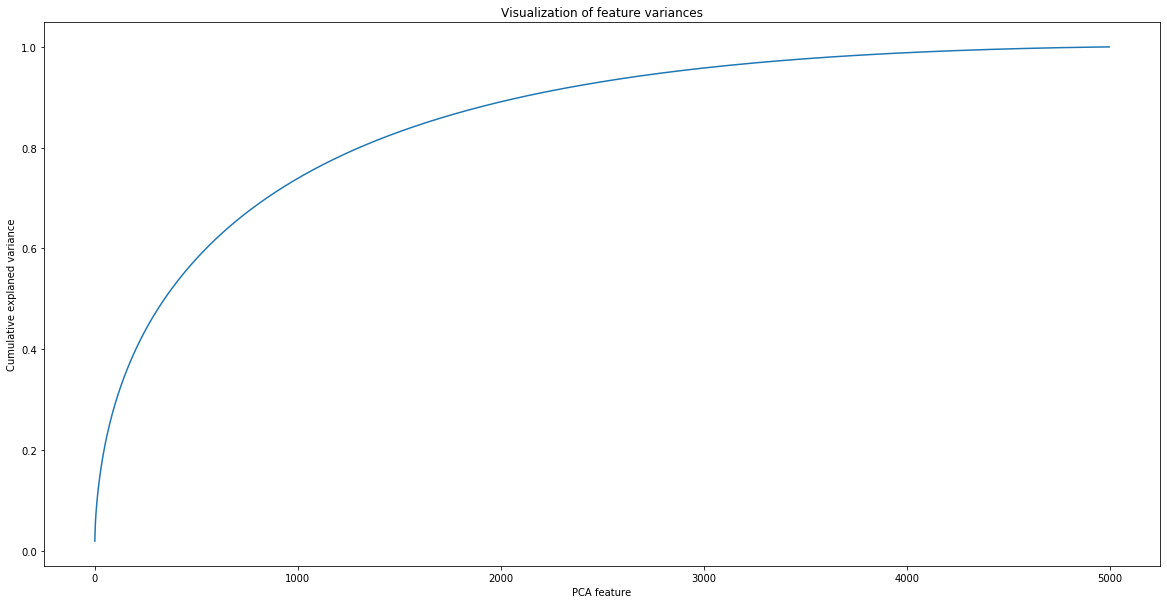

In [9]:
#Making the predictor dataframe and fitting the PCA model on it.
from sklearn.preprocessing import StandardScaler

np_img_features = df_img_features.drop(['image_id','dx'], axis = 1).values
scaled_img_features = StandardScaler().fit_transform(np_img_features)
pca.fit(scaled_img_features)


#Graphing the data
plt.figure(figsize=(20,10))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Visualization of feature variances')
plt.xlabel('PCA feature')
plt.ylabel('Cumulative explaned variance')
plt.show()

In [10]:
#Transforming the image data so that it only contains 6 features.
pca = PCA(0.95)
pca_features = pca.fit_transform(scaled_img_features)
df_pca_features = pd.DataFrame(pca_features)
df_pca_features[['image_id','dx']] = df_img_features[['image_id','dx']]
df_pca_features.to_csv('C:\\Users\\songs\\Desktop\\CSV files\\pca.csv')
df_pca_features.head()

,0,1,2,3,4,5,6,7,8,9,...,2821,2822,2823,2824,2825,2826,2827,2828,image_id,dx
0,-17.197622,7.265878,-2.550361,-0.159952,7.448056,1.649885,0.387693,1.835810,2.950036,-9.277368,...,-4.764403,-0.715089,-3.602659,-2.630041,-0.045274,-4.286926,0.327192,-0.959964,ISIC_0024306,nv
1,-17.815952,15.027976,-7.397805,-4.025595,15.197397,7.608394,-0.146302,2.479199,6.638179,-6.331796,...,-0.091350,0.983975,1.412068,0.751271,-0.053542,2.275187,0.225434,-0.113624,ISIC_0024307,nv
2,-12.318244,2.535372,18.519314,-2.283010,4.328701,-7.302797,-5.529607,-1.425039,-4.626797,1.722985,...,-0.639068,-0.527473,0.095943,1.180825,0.065463,-0.365549,0.309908,-1.439344,ISIC_0024308,nv
3,-0.684587,-9.815083,-7.842098,8.017347,-1.179181,2.815549,3.228892,0.097971,5.368839,-4.451693,...,-2.075900,-0.109621,3.483772,1.325750,-1.946950,0.179406,1.323368,-0.356334,ISIC_0024309,nv
4,32.597737,-14.925823,-23.469787,2.128299,4.329971,5.915953,-12.924405,7.572073,11.535136,5.370676,...,1.480355,0.267202,0.564269,0.808265,0.689129,-0.752351,-0.177477,-0.405549,ISIC_0024310,mel


## Preparing the data for model fitting

Using train_test_split, I split the metadata, unreduced image feature data, reduced image feature data, and a dataframe containing a combination of the reduced image feature data with the correponding patient's metadata into "training" and "testing" sets consisting 70% and 30% of the total data, respectively.

### Metadata

In [3]:
#Importing the csv file
df_metadata = pd.read_csv(r'C:\Users\songs\Desktop\CSV files\dataverse_files\HAM10000_metadata.csv',index_col=0)
print(df_metadata.shape)

(10015, 7)


The metadata contains information about patients in all 10015 images, instead of the 4997 in my training set. Thus, I selected only for images contained in the image feature dataframe.

In [4]:
#We only want the metadata which is contained in the training set, as opposed to all 10015 images.
df_metadata = df_metadata.loc[df_metadata['image_id'].isin(df_img_features['image_id'])]
df_metadata.shape

(4997, 7)

In [5]:
#Converting categorical variables to type "category" for pd.get_dummies later.
df_metadata['dx_type'] = df_metadata['dx_type'].astype('category')
df_metadata['sex'] = df_metadata['sex'].astype('category')
df_metadata['localization'] = df_metadata['localization'].astype('category')
df_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear


When creating the predictor columns (X_meta), I dropped both the lesion and the image id columns because they are unlikely to be of any help in the prediction process and may introduce unnecessary noise.

In [6]:
#Target and predictor columns
y_meta = df_metadata['dx'].values
X_meta = pd.get_dummies(df_metadata.drop(['lesion_id','image_id','dx'], axis = 1)).values

In [7]:
#Creating train and test dataset
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, 
                                                                        test_size = 0.3, random_state=101, stratify=y_meta) 

### Reduced image data

In [8]:
df_pca_features = pd.read_csv('C:\\Users\\songs\\Desktop\\CSV files\\pca.csv')

In [9]:
#Target and predictor columns
y_pca = df_pca_features['dx'].values
X_pca = df_pca_features.drop(['image_id','dx'], axis = 1).values

In [10]:
#Creating train and test dataset
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, 
                                                                    test_size=0.3, random_state=101, stratify=y_pca) 

### Unreduced image data

In [11]:
#Target and predictor columns
y_img = df_img_features['dx'].values
X_img = df_img_features.drop(['image_id','dx'], axis = 1).values

In [12]:
#Creating train and test dataset
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_img, y_img, 
                                                                    test_size=0.3, random_state=101, stratify=y_img) 

### Combining image feature and tabular data

In [15]:
df_combined = df_metadata.merge(right=df_pca_features, how='inner', on=['image_id','dx'])
df_combined.to_csv('C:\\Users\\songs\\Desktop\\CSV files\\whole.csv')

In [13]:
df_combined = pd.read_csv('C:\\Users\\songs\\Desktop\\CSV files\\whole.csv',index_col=0)
df_combined.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Unnamed: 0.1,0,1,...,2819,2820,2821,2822,2823,2824,2825,2826,2827,2828
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,3111,10.583895,-8.562058,...,0.077396,-0.417588,0.038741,-0.832050,-0.117147,-1.279545,0.392000,0.087504,2.492885,0.263184
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,723,63.828696,-6.275236,...,-0.375517,0.111168,-0.381691,0.757508,-0.257798,0.481867,-0.165353,-1.201783,0.585288,0.867134
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2462,2.891863,-2.301103,...,0.871344,1.263791,-2.939438,-1.156450,0.124147,0.799442,-2.828278,-0.909289,-0.579126,-1.361526
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1354,34.999192,11.728751,...,0.448185,-0.375706,0.393892,0.087780,0.166572,0.275787,-0.312343,-0.210616,0.069709,-0.572029
4,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,3541,96.871172,33.728998,...,0.139092,-0.001738,-0.114074,0.080431,0.006198,-0.103402,-0.157379,0.226258,0.186571,0.109356


In [14]:
#Target and predictor columns
y_comb = df_combined['dx'].values
X_comb = pd.get_dummies(df_combined.drop(['lesion_id','image_id','dx'], axis = 1)).values

In [15]:
#Creating train and test dataset
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_comb, y_comb, 
                                                                        test_size=0.3, random_state=101, stratify=y_comb) 

## Fitting classifier models

In this project, I fitted the split data to the following models:
* SVM (LinearSVC)
* Naive Bayes (MultinomialNB)
* DecisionTree
* RandomForestClassifier

For parameter optimization, I used GridSearchCV with f1_score as the scoring method. I chose this method because 1) the data is imbalanced, so accuracy is not a robust measurement 2) it takes into account both precision and recall, providing a more effective measurement of the classifier's accuracy.

To see whether the metadata, unreduced image feature data, reduced image feature data, or a combination of image and metadata is the most effective for classification, I fitted each model used with each dataset and compared their f1-scores to see which dataset yielded the best results, and to see whether there is a pattern across models.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
import pickle
from sklearn.model_selection import cross_val_score

### Model Fitting

In this notebook, I'm going to document how I tuned the hyperparameters for my models and what they are. While I briefly discuss the results, I am not going to document all of the F-scores I got here in detail; for that please look at the final report in the "reports" folder on GitHub.

In [19]:
#Defining the datasets
datasets = [(X_train_meta, X_test_meta, y_train_meta, y_test_meta),
                (X_train_pca, X_test_pca, y_train_pca, y_test_pca),
                (X_train_img, X_test_img, y_train_img, y_test_img),
                (X_train_comb, X_test_comb, y_train_comb, y_test_comb)]
dataset_names = ['metadata','pca','img','comb']

In [37]:
def optimize_params(model, params, X_train, y_train):
    """Select the best parameters out of a dict for a model given training data"""
    clf = model(max_iter=100000)
    clf_cv = RandomizedSearchCV(clf, param_distributions=params, scoring='f1_micro',verbose=10)
    clf_cv.fit(X_train, y_train)
    return clf_cv.best_params_

In [47]:
def fit_model(model, best_params, X_train, y_train):
    """Returns a fitted model given training data"""
    if model == GaussianNB:
        clf = model()
    else:
        clf = model(**best_params)
    clf.fit(X_train, y_train)
    model_fit = clf
    return model_fit

In [17]:
def compare_f1(model):
    X_train, X_test, y_train, y_test = data
    clf = model
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_test, y_test, cv=5)
    return scores

### SVM (LinearSVC)

In [26]:
from sklearn import svm
from tqdm import tqdm

I used LinearSVC instead of SVC here mostly out of consideration for computational time, since there is a dataset with 25088 features and SVM is infamous for the large amount of parameter tuning.

In [ ]:
params_to_test = {'loss': ['hinge', 'squared_hinge'], 
                  'C':np.arange(0.5, 5.5, 0.5), 
                  'multi_class' : ['ovr','crammer_singer']}
params_svm = []
for data in tqdm(datasets):
    X_train, X_test, y_train, y_test = data
    param = optimize_params(svm.LinearSVC, params=params_to_test, X_train=X_train, y_train=y_train)
    params_svm.append(param)

In [33]:
params_svm

[{'multi_class': 'ovr', 'loss': 'squared_hinge', 'C': 2.0},
 {'multi_class': 'crammer_singer', 'loss': 'squared_hinge', 'C': 0.5},
 {'multi_class': 'crammer_singer', 'loss': 'hinge', 'C': 1.0},
 {'multi_class': 'crammer_singer', 'loss': 'hinge', 'C': 5.0}]

In [50]:
for i in range(len(datasets)):
    X_train, X_test, y_train, y_test = datasets[i]
    model = fit_model(svm.LinearSVC, best_params=params_svm[i], X_train=X_train, y_train=y_train)
    filename = 'SVM_' + dataset_names[i] + '.model'
    pickle.dump(model, open(filename, 'wb'))

The f1-scores ranged from 0.65 to 0.77, and of the four, the unreduced image features achieved the highest f1-score (0.67). Surprisingly, the unreduced image features performed better than the reduced image features in LinearSVC. Perhaps there were information in the unreduced image features that helped adumbrate the decision boundaries, or perhaps the other datasets would have beeen better fitted with a nonlinear kernel.

### Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

There are several types of Naive-Bayes models available in scikit-learn. Just to list a few, BinomialNB is designed for data with categorical variables that are binary in nature, MultinomialNB is for use with multinomial prediction, and ComplementNB is supposed to help with unbalanced data. 

In this case, I chose GaussianNB because it is most compatible with numerical (continuous) data. This is important, since there is a large number of negative numerical values included in datasets with image features.

In [40]:
models = []
for i in range(len(datasets)):
    X_train, X_test, y_train, y_test = data[i]
    model = fit_model(GaussianNB, X_train, y_train)
    filename = 'NB_' + dataset_names[i] +'.model'
    pickle.dump(model, open(filename, 'wb'))

The f1-scores ranged from 0.51 to 0.66, and of the four, the reduced image features achieved the highest f1-score (0.66). As expected of GaussianNB, datasets with only continuous values performed better than those containing categorical variables. 

### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
params_to_test = {'max_depth': np.arange(5,55,10), 
                  'min_samples_split': range(2,10),
                  'min_samples_leaf': range(1,10)}
params_dt = []
for data in datasets:
    X_train, X_test, y_train, y_test = data
    param = optimize_params(DecisionTreeClassifier, params=params_to_test, X_train=X_train, y_train=y_train)
    params_dt.append(param)

In [39]:
params_dt

[{'min_samples_split': 8, 'min_samples_leaf': 9, 'max_depth': 5},
 {'min_samples_split': 5, 'min_samples_leaf': 8, 'max_depth': 5},
 {'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 5},
 {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5}]

In [51]:
for i in range(len(datasets)):
    X_train, X_test, y_train, y_test = datasets[i]
    model = fit_model(DecisionTreeClassifier, best_params=params_dt[i], X_train=X_train, y_train=y_train)
    filename = 'DT_' + dataset_names[i] +'.model'
    pickle.dump(model, open(filename, 'wb'))

The f1-scores ranged from 0.63 to 0.73, and of the four, the metadata and the combination tied for the highest f-score. Generally, DecisionTreeClassifier appears to be a more robust classifier compared to Naive Bayes. Perhaps this is because of some interaction between variables that Naive Bayes couldn't capture. 

### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
params_to_test = {'n_estimators': np.arange(10,100,10), 
                  'max_depth': np.arange(5,55,10), 
                  'min_samples_split': range(2,10),
                  'min_samples_leaf': range(1,10)}
params_rfc = []
for data in datasets:
    X_train, X_test, y_train, y_test = data
    param = optimize_params(RandomForestClassifier, params=params_to_test, X_train=X_train, y_train=y_train)
    params_rfc.append(param)
    print('done')

In [43]:
params_rfc

[{'n_estimators': 10,
  'min_samples_split': 6,
  'min_samples_leaf': 3,
  'max_depth': 15},
 {'n_estimators': 30,
  'min_samples_split': 3,
  'min_samples_leaf': 3,
  'max_depth': 35},
 {'n_estimators': 20,
  'min_samples_split': 4,
  'min_samples_leaf': 2,
  'max_depth': 35},
 {'n_estimators': 70,
  'min_samples_split': 6,
  'min_samples_leaf': 1,
  'max_depth': 25}]

In [52]:
for i in range(len(datasets)):
    X_train, X_test, y_train, y_test = datasets[i]
    model = fit_model(RandomForestClassifier, best_params=params_rfc[i], X_train=X_train, y_train=y_train)
    filename = 'RFC_' + dataset_names[i] +'.model'
    pickle.dump(model, open(filename, 'wb'))

The f1-scores ranged from 0.7 to 0.75, and the combination of image data and metadata performed the best (f-score 0.75). Across all datasets aside from the metadata, RandomForest achieved higher f1-scores compared to DecisionTree, with the most improvement seen in data containing numerical values.